$$ \LaTeX \text{ command declarations here.}
\newcommand{\R}{\mathbb{R}}
\renewcommand{\vec}[1]{\mathbf{#1}}
$$

In [2]:
# plotting
%matplotlib inline
from matplotlib import pyplot as plt;

# scientific
import numpy as np;

from scipy import linalg
import matplotlib as mpl
from matplotlib import colors

from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis

# EECS 545:  Machine Learning
## Lecture 06:  Generative models and Logistic Regression
* Instructor:  **Jacob Abernethy**
* Date:  January 27, 2016



# Outline

* Probabilistic Generative Models
    - Gaussian Discriminant Analysis
    - Naïve Bayes
* Discriminant Functions
    - Fisher’s linear discriminant
    - Perceptron learning algorithm


# Probabilistic Generative Models

## Learning the Classifier

Our final goal is to learn the distribution $ P (C_k |  x)$ .

(a) Discriminative Models: Directly model $ P (C_k |  x)$ and learn parameters from the training set.
    
(b) Generative Models: Learn class densities $ P (x |  C_k)$ and priors $ P(C_k) $. Use Bayes' theorem for $ P (C_k |  x)$.



* Bayes' Theorem reduces the classification problem $ P (C_k |  x)$ the distribution of the data.


* Density estimation problems are easy to learn from labeled training data. 
    - $ P (C_k)$
    - $ P (x | C_k)$


* Maximum likelihood parameter estimation.

* For two classes, Bayes' theorem says:
    $$ p(C_1|x) = \frac {p(x|C_1) \cdot p(C_1)} {p(x|C_1) \cdot p(C_1) + p(x|C_2) \cdot p(C_2)} $$
    
    
* Use $ log $ odds:
    $$ a = ln \frac{p(C_1|x)}{p(C_2|x)} = ln \frac{p(x|C_1) \cdot p(C_1)}{p(x|C_2) \cdot p(C_2)} $$
    
    
* To define the posterior via $sigmoid$ :
    $$ p(C_1|x) = \frac {1} {1+ exp(-a)} = \sigma(a) $$

## Discriminative v. Generative: A comparison

* The generative approach is typically model- based, and makes it possible to generate synthetic data from $ p(x|C_k) $.

    – By comparing the synthetic data and real data, we get a sense of how good the generative model is.



* The discriminative approach will typically have fewer parameters to estimate and have less assumptions about data distribution.

    – Linear (e.g., logistic regression) versus quadratic (e.g. Gaussian discriminant analysis) in the dimension of the input.
    
    – Less generative assumptions about the data (however, constructing the features may need prior knowledge)

## Gaussian Discriminant Analysis

* Prior Distribution 
    - $ p(C_k) $: assumed to be constant. (eg. Bernoulli)
    
    
* Likelihood
    - $ p(x| C_k) $: Gaussian distribution
    
    $ p (x| C_k) = \frac{1}{(2\pi) ^\frac{D}{2} |\Sigma|^ \frac{1}{2}} exp \left\{- \frac {1}{2} (x - \mu_k)^T \Sigma^{-1} (x - \mu_k) \right\} $
    
    

* Classification
    - Use Bayes' Rule: For any class $i$,
$$ p(C_i|x) = \frac {p(x|C_i) \cdot p(C_i)} {\Sigma_k p(x|C_k) \cdot p(C_k)} $$

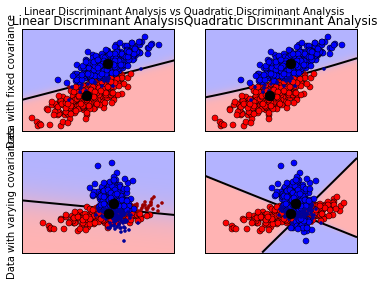

In [3]:
# Credits: Scikit-learn example on Linear and Quadratic Discriminant Analysis with confidence ellipsoid


# colormap
cmap = colors.LinearSegmentedColormap(
    'red_blue_classes',
    {'red': [(0, 1, 1), (1, 0.7, 0.7)],
     'green': [(0, 0.7, 0.7), (1, 0.7, 0.7)],
     'blue': [(0, 0.7, 0.7), (1, 1, 1)]})
plt.cm.register_cmap(cmap=cmap)


###############################################################################
# generate datasets
def dataset_fixed_cov():
    '''Generate 2 Gaussians samples with the same covariance matrix'''
    n, dim = 300, 2
    np.random.seed(0)
    C = np.array([[0., -0.23], [0.83, .23]])
    X = np.r_[np.dot(np.random.randn(n, dim), C),
              np.dot(np.random.randn(n, dim), C) + np.array([1, 1])]
    y = np.hstack((np.zeros(n), np.ones(n)))
    return X, y


def dataset_cov():
    '''Generate 2 Gaussians samples with different covariance matrices'''
    n, dim = 300, 2
    np.random.seed(0)
    C = np.array([[0., -1.], [2.5, .7]]) * 2.
    X = np.r_[np.dot(np.random.randn(n, dim), C),
              np.dot(np.random.randn(n, dim), C.T) + np.array([1, 4])]
    y = np.hstack((np.zeros(n), np.ones(n)))
    return X, y


###############################################################################
# plot functions
def plot_data(lda, X, y, y_pred, fig_index):
    splot = plt.subplot(2, 2, fig_index)
    if fig_index == 1:
        plt.title('Linear Discriminant Analysis')
        plt.ylabel('Data with fixed covariance')
    elif fig_index == 2:
        plt.title('Quadratic Discriminant Analysis')
    elif fig_index == 3:
        plt.ylabel('Data with varying covariances')

    tp = (y == y_pred)  # True Positive
    tp0, tp1 = tp[y == 0], tp[y == 1]
    X0, X1 = X[y == 0], X[y == 1]
    X0_tp, X0_fp = X0[tp0], X0[~tp0]
    X1_tp, X1_fp = X1[tp1], X1[~tp1]

    # class 0: dots
    plt.plot(X0_tp[:, 0], X0_tp[:, 1], 'o', color='red')
    plt.plot(X0_fp[:, 0], X0_fp[:, 1], '.', color='#990000')  # dark red

    # class 1: dots
    plt.plot(X1_tp[:, 0], X1_tp[:, 1], 'o', color='blue')
    plt.plot(X1_fp[:, 0], X1_fp[:, 1], '.', color='#000099')  # dark blue

    # class 0 and 1 : areas
    nx, ny = 200, 100
    x_min, x_max = plt.xlim()
    y_min, y_max = plt.ylim()
    xx, yy = np.meshgrid(np.linspace(x_min, x_max, nx),
                         np.linspace(y_min, y_max, ny))
    Z = lda.predict_proba(np.c_[xx.ravel(), yy.ravel()])
    Z = Z[:, 1].reshape(xx.shape)
    plt.pcolormesh(xx, yy, Z, cmap='red_blue_classes',
                   norm=colors.Normalize(0., 1.))
    plt.contour(xx, yy, Z, [0.5], linewidths=2., colors='k')

    # means
    plt.plot(lda.means_[0][0], lda.means_[0][1],
             'o', color='black', markersize=10)
    plt.plot(lda.means_[1][0], lda.means_[1][1],
             'o', color='black', markersize=10)

    return splot


def plot_ellipse(splot, mean, cov, color):
    v, w = linalg.eigh(cov)
    u = w[0] / linalg.norm(w[0])
    angle = np.arctan(u[1] / u[0])
    angle = 180 * angle / np.pi  # convert to degrees
    # filled Gaussian at 2 standard deviation
    ell = mpl.patches.Ellipse(mean, 2 * v[0] ** 0.5, 2 * v[1] ** 0.5,
                              180 + angle, color=color)
    ell.set_clip_box(splot.bbox)
    ell.set_alpha(0.5)
    splot.add_artist(ell)
    splot.set_xticks(())
    splot.set_yticks(())


def plot_lda_cov(lda, splot):
    plot_ellipse(splot, lda.means_[0], lda.covariance_, 'red')
    plot_ellipse(splot, lda.means_[1], lda.covariance_, 'blue')


def plot_qda_cov(qda, splot):
    plot_ellipse(splot, qda.means_[0], qda.covariances_[0], 'red')
    plot_ellipse(splot, qda.means_[1], qda.covariances_[1], 'blue')

###############################################################################
for i, (X, y) in enumerate([dataset_fixed_cov(), dataset_cov()]):
    # Linear Discriminant Analysis
    lda = LinearDiscriminantAnalysis(solver="svd", store_covariance=True)
    y_pred = lda.fit(X, y).predict(X)
    splot = plot_data(lda, X, y, y_pred, fig_index=2 * i + 1)
    plot_lda_cov(lda, splot)
    plt.axis('tight')

    # Quadratic Discriminant Analysis
    qda = QuadraticDiscriminantAnalysis(store_covariances=True)
    y_pred = qda.fit(X, y).predict(X)
    splot = plot_data(qda, X, y, y_pred, fig_index=2 * i + 2)
    plot_qda_cov(qda, splot)
    plt.axis('tight')
plt.suptitle('Linear Discriminant Analysis vs Quadratic Discriminant Analysis')
plt.show()

## Class Conditional Densities

Suppose we model $ p(x |C_k) $ as Gaussians with the _same_ _covariance_ matrix:

$ p (x| C_k) = \frac{1}{(2\pi) ^\frac{D}{2} |\Sigma|^ \frac{1}{2}} exp \left\{- \frac {1}{2} (x - \mu_k)^T \Sigma^{-1} (x - \mu_k) \right\} $

This gives us $ p(C_1|x) = \sigma(w^T x + w_0) $

where $ w = \Sigma^{-1}(\mu_1 - \mu_2) $ 

and $ w_0 = -\frac{1}{2} \mu_1^T \Sigma ^{-1} \mu_1 + \frac{1}{2} \mu_2^T \Sigma ^{-1} \mu_2 + ln \frac {p(C_1)}{p(C_2)} $

## Derivation

$$
\begin{align}
P (x, C_1) 
&= P(x|C_1) \cdot P(C_1) \\
&= \frac{1}{(2\pi) ^\frac{D}{2} |\Sigma|^ \frac{1}{2}} exp \left\{- \frac {1}{2} (x - \mu_1)^T \Sigma^{-1} (x - \mu_1) \right\} \cdot P(C_1)
\end{align}
$$


$$
\begin{align}
P (x, C_2) 
&= P(x|C_2) \cdot P(C_2) \\
&=  \frac{1}{(2\pi) ^\frac{D}{2} |\Sigma|^ \frac{1}{2}} exp \left\{- \frac {1}{2} (x - \mu_2)^T \Sigma^{-1} (x - \mu_2) \right\} \cdot P(C_2)
\end{align}
$$

__"Log Odds"__
$$
\begin{align}
log \frac {p(C_1|x)}{p(C_2|x)} 
&= log \frac {p(C_1|x)}{1 - p(C_1|x)} \\
&= log \frac{exp \left\{- \frac {1}{2} (x - \mu_1)^T \Sigma^{-1} (x - \mu_1) \right\}}{exp \left\{- \frac {1}{2} (x - \mu_2)^T \Sigma^{-1} (x - \mu_2) \right\}} + log \frac{P(C_1)}{P(C_2)} \\
&= \left\{- \frac {1}{2} (x - \mu_1)^T \Sigma^{-1} (x - \mu_1) \right\} - \left\{- \frac {1}{2} (x - \mu_2)^T \Sigma^{-1} (x - \mu_2) \right\} +  log \frac{P(C_1)}{P(C_2)} \\
&= (\mu_1 - \mu_2)^T \Sigma^{-1} x - \frac{1}{2} \mu_1\Sigma^{-1}\mu_1 + \frac{1}{2} \mu_2\Sigma^{-1}\mu_2 + log \frac{P(C_1)}{P(C_2)} \\
&= (\Sigma^{-1}(\mu_1 - \mu_2))^T x + w_0
\end{align}
$$

where $ w_0 = -\frac{1}{2} \mu_1^T \Sigma ^{-1} \mu_1 + \frac{1}{2} \mu_2^T \Sigma ^{-1} \mu_2 + log \frac {p(C_1)}{p(C_2)}$

## Class-Conditional Densities 
## (for shared covariances)

* $ P(C_k|x) $ is a sigmoid function: $ \sigma(a) = \frac {1}{1+exp(-a)} $

- with logg-odds (_logit function_):
$ a = log(\frac{\sigma}{1-\sigma} = (\Sigma^{-1}(\mu_1 - \mu_2))^T x + w_0 $

where $ w_0 = -\frac{1}{2} \mu_1^T \Sigma ^{-1} \mu_1 + \frac{1}{2} \mu_2^T \Sigma ^{-1} \mu_2 + log \frac {p(C_1)}{p(C_2)} $

* Generalizes to normalized exponential or _softmax_: $ p_i = \frac{exp(q_i)}{\Sigma_j exp(q_j)}$

## Sigmoid Function

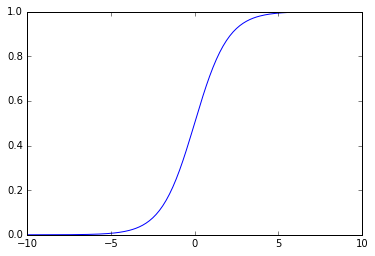

In [10]:
# Plot sigmoid function
import math
def sigmoid(x):
    a = []
    for item in x:
        a.append(1/(1+math.exp(-item)))
    return a
x = np.arange(-10., 10., 0.1)
sig = sigmoid(x)
plt.plot(x,sig);

## Linear Decision Boundaries

* With the same covariance matrices, the boundary $ p(C_1|x) = p(C_2|x)$ is linear.
    - Different priors $p(C_1), P(C_2)$ just shift it around.
    
<img src="linear_db.png" width=750px, align="middle">

## Learning parameters via maximum likelihood

* Given training data $\{(x^{(1)}, t^{(1)}), .... , (x^{(N)}, t^{(N)})\}$ and a generative model (_shared covariance_)

$$ p(t) = \phi^t (1-\phi)^{(1-t)} $$

$$ p(x|t=0) = \frac{1}{\sqrt{2\pi} |\Sigma|^\frac{1}{2}} exp (- \frac {1}{2} (x - \mu_0)^T \Sigma^{-1} (x - \mu_0) ) $$

$$ p(x|t=1) = \frac{1}{\sqrt{2\pi} |\Sigma|^\frac{1}{2}} exp (- \frac {1}{2} (x - \mu_1)^T \Sigma^{-1} (x - \mu_1) ) $$



__log likelihood__

$$
\begin{align}
log (L)  
&= \prod_{i=1}^{N} P(X^{(i)}, t^{(i)}) \\
&= \sum_{i=1}^{N} log P(X^{(i)}, t^{(i)})
\end{align}
$$

## Learning via maximum likelihood

Maximum likelihood estimation solutions

$$ \phi = \frac{1}{N} \sum_{i=1}^{N} 1\{t_i =1\} $$

$$ \mu_0 = \frac{\sum_{i=1}^{N} 1\{t_i = 0\} x_i}{\sum_{i=1}^{N} 1\{t_i = 0\}}  $$


$$ \mu_1 = \frac{\sum_{i=1}^{N} 1\{t_i = 1\} x_i}{\sum_{i=1}^{N} 1\{t_i = 1\}}  $$

$$ \Sigma = \frac{1}{N} \sum_{i=1}^{N} (x_i - \mu_{t_i})(x_i - \mu_{t_i})^T $$

## The case of Different Covariances

* Decision boundaries can be quadratic.

<img src="cov.png" width=750px, align="middle">

## GDA v. Logistic Regression

* For an M-dimensional feature space, 
    - Logistic regression has to fit M parameters.
    - GDA has to fit 
        * 2M parameters for means of $ p(x|C_1)$ and $ p(x|C_2)$
        * M(M+1)/2 parameters for the shared covariance matrix.




* Logistic regression has less parameters and is more flexible about data distribution.


* GDA has a stronger modeling assumption, and works well when the distribution follows the assumption.